# Lab 3- Training the Deep Neural Network in your head (aka Hand Scan)

DUE: 10 am, 2/10/2017. A snapshot will be taken at this time. We will discuss these problems throughout the following week.

## Introduction
Before High Energy Physicists used computers with automatic reconstruction to turn raw data into features, they relied on hand scans performed by people. In this lab we will setup a hand scan using the Liquid Argon TPC (LArTPC) data we looked at last time. The task will be to identify the type of particle. You will be the handscanner. The steps are as follows:

    * Data Engineering: Load data from various files
    * Training: Train the handscanner by presenting images of the data with the labels.
    * Validation: Ask the handscanner to classify some randomly selected images, and see how well they do.


## Data Engineering

Our data is stored in a bunch of files. You can see the files by listing the directory using the unix "ls" command. You can call shell commands, like "ls", from Jupyter:

In [1]:
!ls /data/LArIAT/h5_files/

antielectron_0-1462146945.h5   nuebar_NC_4-1469512487.h5
antielectron_0-1462204074.h5   nuebar_NC_4-1469512529.h5
antielectron_0-1462522993.h5   nuebar_NC_4-1469512634.h5
antielectron_1-1462146945.h5   nuebar_NC_4-1469512704.h5
antielectron_1-1462204074.h5   nuebar_NC_4-1469512742.h5
antielectron_1-1462522993.h5   nuebar_NC_4-1469512962.h5
antielectron_10-1462146945.h5  nuebar_NC_4-1469513002.h5
antielectron_10-1462204074.h5  nuebar_NC_4-1469513040.h5
antielectron_10-1462522993.h5  nuebar_NC_4-1469513081.h5
antielectron_11-1462146945.h5  nuebar_NC_4-1469513114.h5
antielectron_11-1462204074.h5  nuebar_NC_4-1469513150.h5
antielectron_11-1462522993.h5  nuebar_NC_4-1469513218.h5
antielectron_12-1462204074.h5  nuebar_NC_4-1469513267.h5
antielectron_12-1462522993.h5  nuebar_NC_4-1469513311.h5
antielectron_13-1462204074.h5  nuebar_NC_4-1469513349.h5
antielectron_13-1462522993.h5  nuebar_NC_4-1469513392.h5
antielectron_14-1462146945.h5  nuebar_NC_4-1469513434.h5
antielectron_14-1462204074.h5  

That's a lot of files. Lets count how many... in python. There are a variety of ways of getting back a directory listing in python. Here's one:

In [3]:
import glob
Files=glob.glob("/data/LArIAT/h5_files/*")
print "Number of Files:", len(Files)
print "First Filename:", Files[0]

Number of Files: 6745
First Filename: /data/LArIAT/h5_files/electron_9-1463722329.h5


Looking at the file names, you notice that they start with the type of particle. Each file contains a samples of "events". In each event, we simulated shooting a particle into the detector and stored the response. The name of the file specifies what type of particle was simulated in that file.

Let's try to figure out what types. We'll loop over the file names, strip out the first part of the file name, and store it in a dictionary:

In [4]:
import os

FileCount= {}  # Store the count here
FileLists= {}  # Organize the files by particle type here.



for aFile in Files:
    # Lets strip the path (everything before the "/"s) and get the filename:
    FileName=os.path.basename(aFile)
    
    # Now use everything before the first "_" as the particle name
    ParticleName=FileName.split('_')[0]
    
    if ParticleName in FileCount.keys():
        FileCount[ParticleName]+=1
        FileLists[ParticleName].append(aFile)
    else:
        FileCount[ParticleName]=1
        FileLists[ParticleName]= [aFile]

print FileCount.keys()
print "Number of types of particles:", len(FileCount.keys())
print "----------------------------------------------------------"
print "Number of files for each particle type:", FileCount
print "----------------------------------------------------------"
print "First file of each type:"
for aFile in FileLists:
    print aFile,":",FileLists[aFile][0]

['numu', 'kaonPlus', 'antielectron', 'pion', 'numubar', 'nuebar', 'photon', 'antiproton', 'proton', 'electron', 'muon', 'pionPlus', 'kaonMinus', 'nue', 'antimuon', 'pionMinus']
Number of types of particles: 16
----------------------------------------------------------
Number of files for each particle type: {'numu': 944, 'kaonPlus': 417, 'antielectron': 48, 'pion': 240, 'numubar': 747, 'nuebar': 631, 'photon': 185, 'antiproton': 360, 'proton': 268, 'electron': 339, 'muon': 277, 'pionPlus': 399, 'kaonMinus': 396, 'nue': 616, 'antimuon': 411, 'pionMinus': 467}
----------------------------------------------------------
First file of each type:
numu : /data/LArIAT/h5_files/numu_CC_7-1468443731.h5
kaonPlus : /data/LArIAT/h5_files/kaonPlus_11-1466643524.h5
antielectron : /data/LArIAT/h5_files/antielectron_17-1462522993.h5
pion : /data/LArIAT/h5_files/pion_0_19-1463161413.h5
numubar : /data/LArIAT/h5_files/numubar_CC_1-1469306203.h5
nuebar : /data/LArIAT/h5_files/nuebar_CC_3-1469468394.h5
pho

We can count how many examples are in each file by open them up in h5py like we did in the last lab:

In [6]:
import h5py

f=h5py.File(FileLists["pionPlus"][0],"r")

# Read the First N_Events. Data is stored as float16, lets store it as float32 to avoid overflows later when we sum.
print "Shape of the data:", f["features"].shape
print "Number of events in file:", f["features"].shape[0]

f.close()

Shape of the data: (500, 2, 240, 4096)
Number of events in file: 500


### Exercise 3.1- Basic File Manipulation

Create two dictionaries. Store the total number of events of each particle type in one. Store the number events in each file in another. 

In [7]:
N_Events_perType = {}
N_Events_perFile = {}

### BEGIN SOLUTION

for aFile in Files:
    FileName=os.path.basename(aFile)
    f=h5py.File(aFile,"r")
    s=float(f["features"].shape[0])
    
    ParticleName=FileName.split('_')[0]
    
    if ParticleName in N_Events_perType.keys():
        N_Events_perType[ParticleName]+=s
    else:
        N_Events_perType[ParticleName]=s
        
    if FileName in N_Events_perFile.keys():
        N_Events_perFile[FileName]+=s
    else:
        N_Events_perFile[FileName]=s
        
print N_Events_perType.keys()
print "Number of types of particles:", len(N_Events_perType.keys())
print "----------------------------------------------------------"
print "Number of files for each particle type:", N_Events_perType
print "----------------------------------------------------------"

print "Number of types of particles:", len(N_Events_perFile.keys())
print "----------------------------------------------------------"
print "Number of files for each particle type:", N_Events_perFile
print "----------------------------------------------------------"

# Fill in your solution here        
    
### END SOLUTION

['numu', 'kaonPlus', 'antielectron', 'pion', 'numubar', 'nuebar', 'photon', 'antiproton', 'proton', 'electron', 'muon', 'pionPlus', 'kaonMinus', 'nue', 'antimuon', 'pionMinus']
Number of types of particles: 16
----------------------------------------------------------
Number of files for each particle type: {'numu': 2048534.0, 'kaonPlus': 1178040.0, 'antielectron': 60000.0, 'pion': 620140.0, 'numubar': 1720054.0, 'nuebar': 1547500.0, 'photon': 345075.0, 'antiproton': 762640.0, 'proton': 547540.0, 'electron': 773190.0, 'muon': 584102.0, 'pionPlus': 860138.0, 'kaonMinus': 860100.0, 'nue': 1520000.0, 'antimuon': 852138.0, 'pionMinus': 957640.0}
----------------------------------------------------------
Number of types of particles: 6745
----------------------------------------------------------
Number of files for each particle type: {'pionMinus_5-1466714027.h5': 2500.0, 'numubar_CC_6-1469306679.h5': 2500.0, 'pionPlus_14-1466780135.h5': 2500.0, 'photon_8-1466605316.h5': 2500.0, 'nue_NC_18

## Training

We will use matplotlib for most of our plotting. There are lots of tutorials and primers out there that you can find searching the web. A good tutorial can be found in the [Scipy Lectures](http://www.scipy-lectures.org/intro/matplotlib/matplotlib.html). Look through these on your own time, it is not necessary for doing these exercise.

The raw data from a LArTPC detector looks like an image. The LArIAT detector, which we have simulated, has 2 readout views. The following code gives you an example how to plot these images. 

Data shape: (500, 2, 240, 4096)


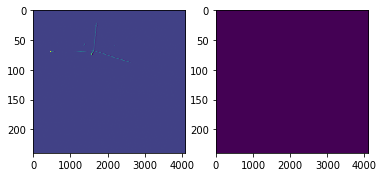

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Load the first pion file
f=h5py.File(FileLists["pionPlus"][0],"r")

# Get the images
images=f["features"]

print "Data shape:", images.shape

def PlotEvent(image):
    # Make two plots. Create a 1 by 2 grid the plots.
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)

    # Plot the first view. Note: [EventNumber, View] = [0,0]
    s=image[0].shape
    image1=np.zeros(s)
    for ii in range(s[0]):
        for jj in range(s[1]):
            
            image1[ii,jj]=float(image[0][ii,jj])
            
    ax1.imshow(image1)

    # Plot the second view 
    s=image[1].shape
    image2=np.zeros(s)
    for ii in range(s[0]):
        for jj in range(s[1]):
            
            image1[ii,jj]=float(image[1][ii,jj])
            
    ax2.imshow(image2)

    # The data is 240 by 4096. Change the aspect ratio so the plot is not squished. 
    ax1.set_aspect(16)  
    ax2.set_aspect(16) 

# Plot the 5th Event
PlotEvent(images[4])

f.close()

### Exercise 3.2.1- Setup Training

Write a function that takes a file, and creates a grid of plots showing the first N events. Use this function to plot the first 9 events in the first file of each particle type in a 3 by 3 grid. You only need to show one view.

numu :
kaonPlus :
antielectron :
pion :
numubar :
nuebar :
photon :
antiproton :
proton :
electron :
muon :
pionPlus :
kaonMinus :
nue :
antimuon :
/data/LArIAT/h5_files/antimuon_12-1466216931.h5
pionMinus :


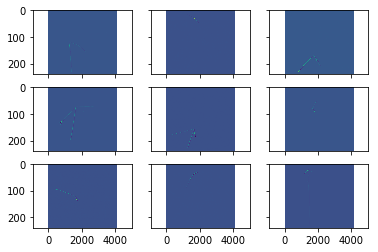

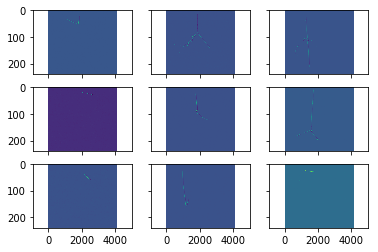

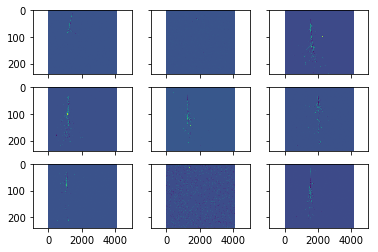

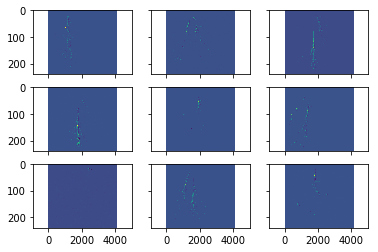

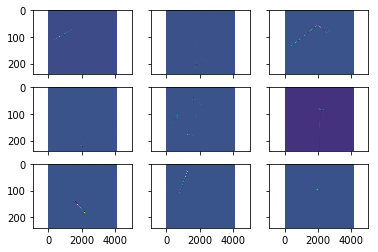

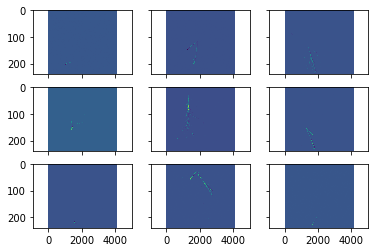

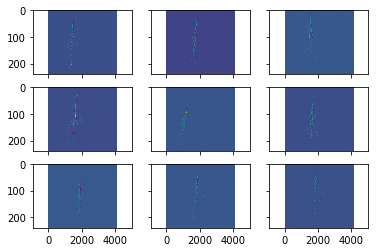

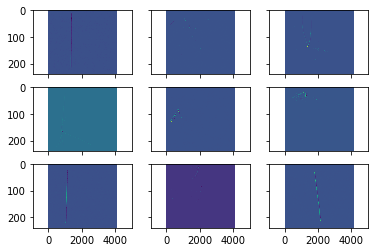

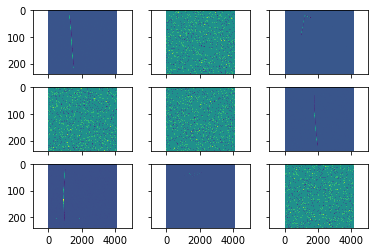

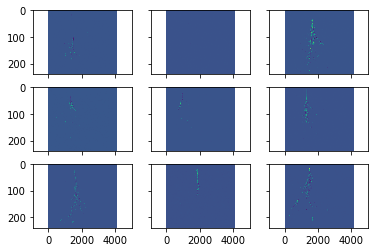

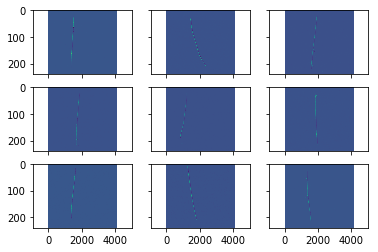

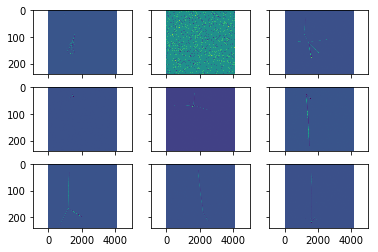

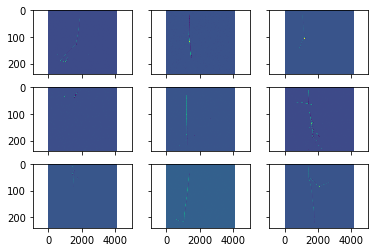

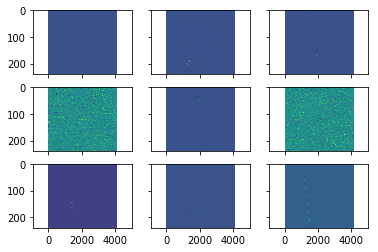

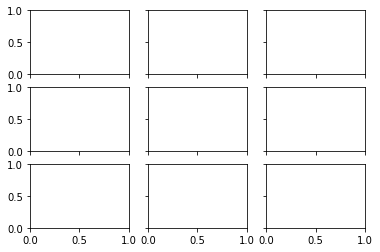

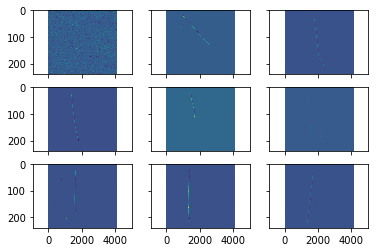

In [9]:
def PlotEvent1(image,ax):
    # Make two plots. Create a 1 by 2 grid the plots.
    
    # Plot the first view. Note: [EventNumber, View] = [0,0]
    s=image[0].shape
    image1=np.zeros(s)
    for ii in range(s[0]):
        for jj in range(s[1]):
            
            image1[ii,jj]=float(image[0][ii,jj])
            
    ax.imshow(image1)
    
    ax.set_aspect(16)  


def PlotEvents(FileName, N_Events):
    ### BEGIN SOLUTION

    # Fill in your solution here     
    fig,axes =plt.subplots(3,3,sharex=True,sharey=True)
    
    f=h5py.File(FileName,"r")

    # Get the images
    images=f["features"]
    if images.shape[0]<N_Events:
        print FileName
        
    else:
    
        for i in range(N_Events):
            nr=i/3
            nc=int(np.mod(i,3))
            PlotEvent1(images[i],axes[nr,nc])
    
    f.close()
    
    ### END SOLUTION
    pass

N_Events=9

i=0
for aFile in FileLists:
    i+=1
    FileName=FileLists[aFile][0]
    ParticleName=os.path.basename(FileName).split('_')[0]
    
    print ParticleName,":"
    PlotEvents(FileName,9)
    

### Exercise 3.2.2- Train Yourself

By looking closely at each particle type, identify at least one "feature" that would allow you to by eye uniquely identify that particle type. 

Type you answer in this box.

### BEGIN SOLUTION

- muon/antimuon: your description here
- electron/antielectron: your description here
- pion: your description here
- pionPlus/pionMinus: your description here
- kaonPlus/kaonMinus: your description here
- photon: your description here
- nue/nuebar: your description here
- numu/numubar: your description here
- proton/antiproton: your description here

### END SOLUTION

## Validation (Homework)

Now we have to setup a validation process. We will first assign each particle type a unique index. Then we will load some events of each particle type, mix them while keeping track of the indecies. Finally we will present the images to the handscanner, ask them to classify, and keep track of how well they do.

Read through and try to understand the following code which setups up 2 dictionaries we will use to uniquely identify particle types. 

In [10]:
import numpy as np

# Assign index to particle type
ParticleTypesIndexMap = {}

for i,ParticleType in enumerate(FileLists.keys()):    
    ParticleTypesIndexMap[ParticleType]=i

#print ParticleTypesIndexMap

# Merge particle/anti-particle
for ParticleName in ParticleTypesIndexMap:
    if 'bar' in ParticleName:
        ParticleTypesIndexMap[ParticleName]=ParticleTypesIndexMap[ParticleName.split('bar')[0]]
        
        
    if 'anti' in ParticleName:
        ParticleTypesIndexMap[ParticleName]=ParticleTypesIndexMap[ParticleName.split('anti')[1]]

    if 'Minus' in ParticleName:
        ParticleTypesIndexMap[ParticleName]=ParticleTypesIndexMap[ParticleName.split('Minus')[0]+"Plus"]
    
print "Index map:"
print ParticleTypesIndexMap

# Reverse Map
ParticleTypesIndexMapR={}

for p in ParticleTypesIndexMap:
    print p
    if ParticleTypesIndexMap[p] not in ParticleTypesIndexMapR:
        ParticleTypesIndexMapR[ParticleTypesIndexMap[p]]=p

print "Reverse Index map:"
print ParticleTypesIndexMapR



Index map:
{'numu': 0, 'nue': 13, 'antielectron': 9, 'pion': 3, 'numubar': 0, 'nuebar': 13, 'photon': 6, 'electron': 9, 'proton': 8, 'antiproton': 8, 'muon': 10, 'pionPlus': 11, 'kaonMinus': 1, 'kaonPlus': 1, 'antimuon': 10, 'pionMinus': 11}
numu
nue
antielectron
pion
numubar
nuebar
photon
electron
proton
antiproton
muon
pionPlus
kaonMinus
kaonPlus
antimuon
pionMinus
Reverse Index map:
{0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}


Now we load the data and mix them:

In [11]:
Data_X = None
Data_Y = None
N_Events_perType=10

for ParticleType in FileLists:
    # Open the first file
    FileName=FileLists[ParticleType][1] # we will take the 2nd file so we don't use the training sample for validation
    print "Opening:",FileName
    f=h5py.File(FileName,"r")
    
    # Get the images/features
    images=np.array(f["features"][:N_Events_perType])
    
    # Warn if not enough events
    N_Events_read=images.shape[0]
    if not N_Events_read==N_Events_perType:
        print "Warning: Sample", FileName, "had only",N_Events_read,"events."
    
    # Assign labels
    labels=np.empty(N_Events_read)
    labels.fill(ParticleTypesIndexMap[ParticleType])

    # Store some of them
    try:
        # If we have already read some data, add to it
        Data_X=np.concatenate((Data_X,images))
        Data_Y=np.concatenate((Data_Y,labels))
    except:
        # If we haven't read any data yet
        Data_X=images
        Data_Y=labels
    
        
    f.close()

print Data_X.shape, Data_Y.shape

def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
    
Data_X,Data_Y=shuffle_in_unison_inplace(Data_X,Data_Y)    


Opening: /data/LArIAT/h5_files/numu_CC_7-1469162877.h5
Opening: /data/LArIAT/h5_files/kaonPlus_5-1466605529.h5
Opening: /data/LArIAT/h5_files/antielectron_2-1462204074.h5
Opening: /data/LArIAT/h5_files/pion_0_19-1465222696.h5
Opening: /data/LArIAT/h5_files/numubar_CC_10-1469306203.h5
Opening: /data/LArIAT/h5_files/nuebar_NC_0-1469513434.h5
Opening: /data/LArIAT/h5_files/photon_2-1466642559.h5
Opening: /data/LArIAT/h5_files/antiproton_7-1466998552.h5
Opening: /data/LArIAT/h5_files/proton_15-1466439654.h5
Opening: /data/LArIAT/h5_files/electron_19-1464793391.h5
Opening: /data/LArIAT/h5_files/muon_14-1466218429.h5
Opening: /data/LArIAT/h5_files/pionPlus_1-1463590721.h5
Opening: /data/LArIAT/h5_files/kaonMinus_14-1463590719.h5
Opening: /data/LArIAT/h5_files/nue_NC_14-1461971806.h5
Opening: /data/LArIAT/h5_files/antimuon_3-1466967198.h5
Opening: /data/LArIAT/h5_files/pionMinus_5-1466714027.h5
(155, 2, 240, 4096) (155,)


In [ ]:
Data_Y

##  Exercise 3.3.1

The following code presents images and asks the handscanner for a type. Read through it carefully. Try it out. Then instrument this code so it keeps track of success and failures. The goal is to create a confusion matrix, a table that keeps track of how often each particle type is correctly identified and how often it is misidentified as any other type.  

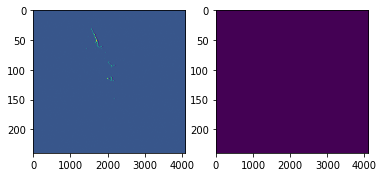

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:1
You selected: kaonMinus
You are wrong!


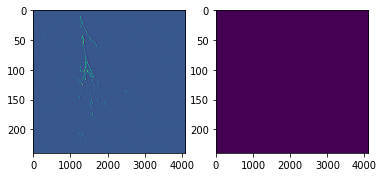

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:3
You selected: pion
You are correct!


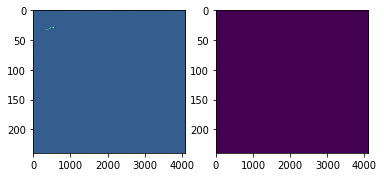

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:8
You selected: proton
You are wrong!


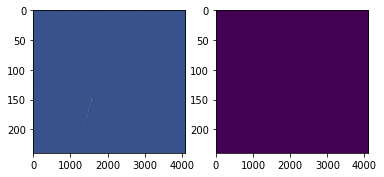

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:9
You selected: antielectron
You are wrong!


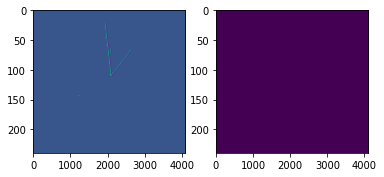

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:10
You selected: muon
You are wrong!


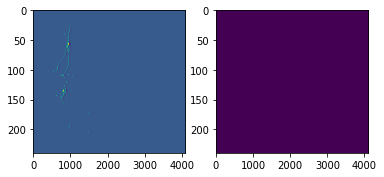

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:3
You selected: pion
You are wrong!


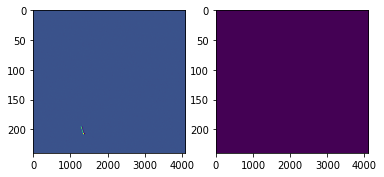

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:6
You selected: photon
You are wrong!


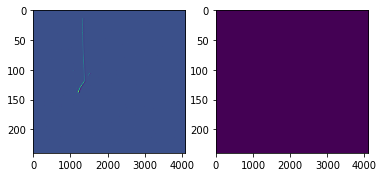

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:6
You selected: photon
You are wrong!


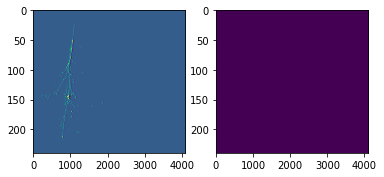

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:3
You selected: pion
You are wrong!


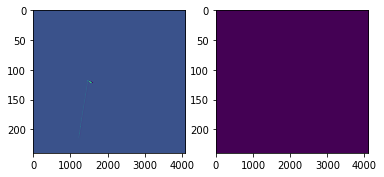

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:0
You selected: numu
You are correct!


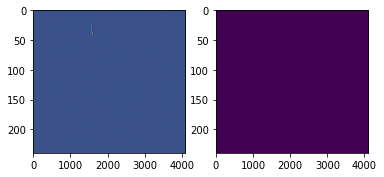

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:11
You selected: pionPlus
You are correct!


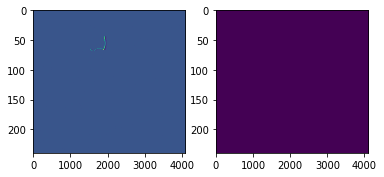

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:13
You selected: nue
You are wrong!


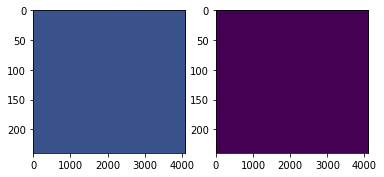

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:9
You selected: antielectron
You are wrong!


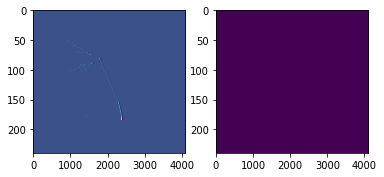

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:8
You selected: proton
You are wrong!


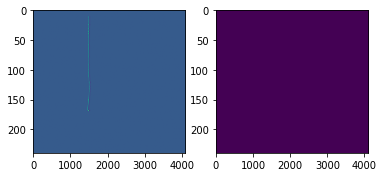

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:11
You selected: pionPlus
You are correct!


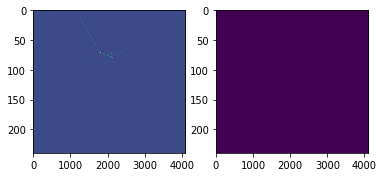

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:13
You selected: nue
You are wrong!


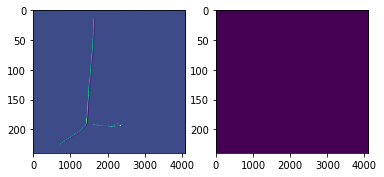

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:10
You selected: muon
You are wrong!


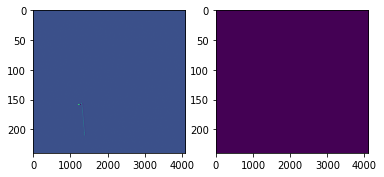

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:-1


In [23]:
import matplotlib.pyplot as plt
View=0

status=np.zeros(len(Data_Y))
cm=np.zeros([14,14])
for i,image in enumerate(Data_X):
    PlotEvent(image)
    plt.show()

    
    print "Select Type from:", ParticleTypesIndexMapR
    try:
        answer=int(raw_input('Input:'))
    except ValueError:
        print "Not a number"
        
    # Stop loop
    if answer==-1:
        break
    
    print "You selected:", ParticleTypesIndexMapR[answer]
    
    if answer==Data_Y[i]:
        print "You are correct!"
        status[i]=1
    else:
        print "You are wrong!"
        

    
    cm[int(answer),int(Data_Y[i])]+=1
    
        

In [26]:
# Confusion matrix
for i in range(14):
    print cm[i,:]

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


##  Exercise 3.3.2

Make yourself the handscanner. Use above code to go through the full data sample and create a confusion matrix.

Opening: /data/LArIAT/h5_files/numu_CC_7-1469162877.h5
Opening: /data/LArIAT/h5_files/kaonPlus_5-1466605529.h5
Opening: /data/LArIAT/h5_files/antielectron_2-1462204074.h5
Opening: /data/LArIAT/h5_files/pion_0_19-1465222696.h5
Opening: /data/LArIAT/h5_files/numubar_CC_10-1469306203.h5
Opening: /data/LArIAT/h5_files/nuebar_NC_0-1469513434.h5
Opening: /data/LArIAT/h5_files/photon_2-1466642559.h5
Opening: /data/LArIAT/h5_files/antiproton_7-1466998552.h5
Opening: /data/LArIAT/h5_files/proton_15-1466439654.h5
Opening: /data/LArIAT/h5_files/electron_19-1464793391.h5
Opening: /data/LArIAT/h5_files/muon_14-1466218429.h5
Opening: /data/LArIAT/h5_files/pionPlus_1-1463590721.h5
Opening: /data/LArIAT/h5_files/kaonMinus_14-1463590719.h5
Opening: /data/LArIAT/h5_files/nue_NC_14-1461971806.h5
Opening: /data/LArIAT/h5_files/antimuon_3-1466967198.h5
Opening: /data/LArIAT/h5_files/pionMinus_5-1466714027.h5
(80, 2, 240, 4096) (80,)


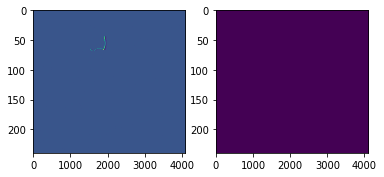

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:0
You selected: numu
You are correct!


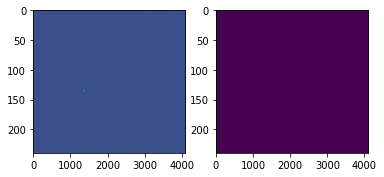

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:13
You selected: nue
You are correct!


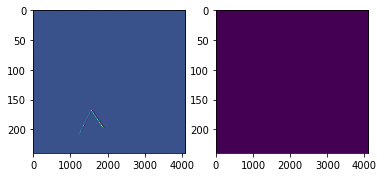

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:9
You selected: antielectron
You are wrong!


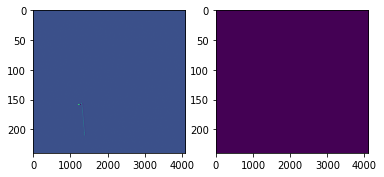

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:9
You selected: antielectron
You are wrong!


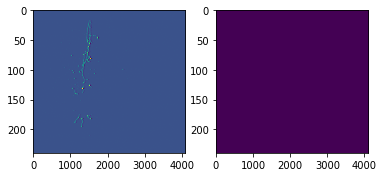

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:3
You selected: pion
You are wrong!


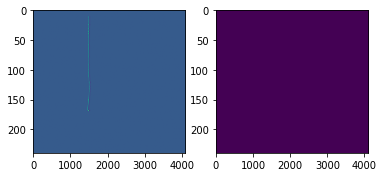

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:11
You selected: pionPlus
You are correct!


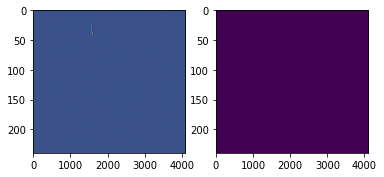

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:6
You selected: photon
You are wrong!


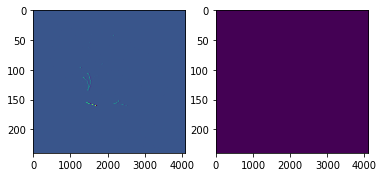

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:1
You selected: kaonMinus
You are wrong!


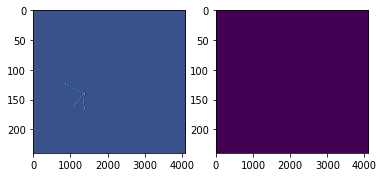

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:0
You selected: numu
You are wrong!


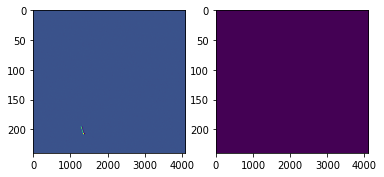

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:0
You selected: numu
You are correct!


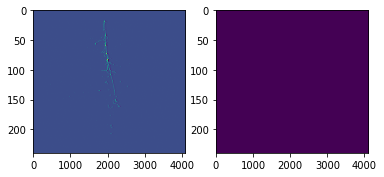

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:3
You selected: pion
You are wrong!


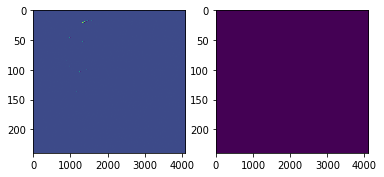

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:1
You selected: kaonMinus
You are correct!


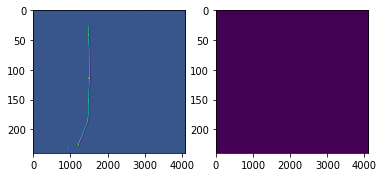

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:11
You selected: pionPlus
You are wrong!


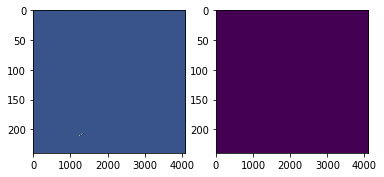

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:8
You selected: proton
You are wrong!


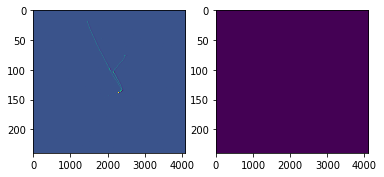

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:3
You selected: pion
You are wrong!


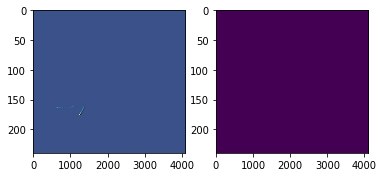

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:11
You selected: pionPlus
You are wrong!


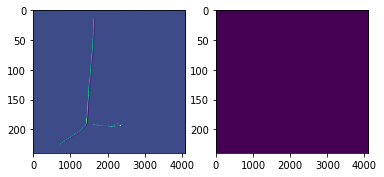

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:6
You selected: photon
You are wrong!


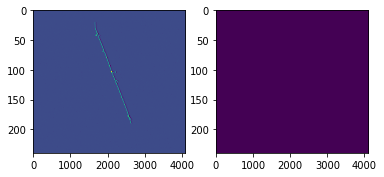

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:8
You selected: proton
You are wrong!


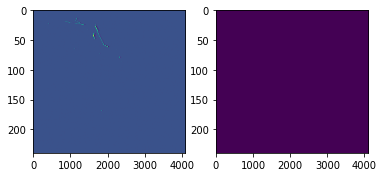

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:1
You selected: kaonMinus
You are wrong!


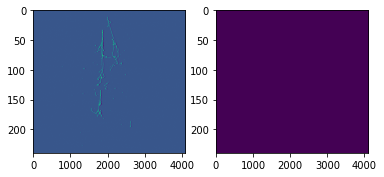

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:3
You selected: pion
You are correct!


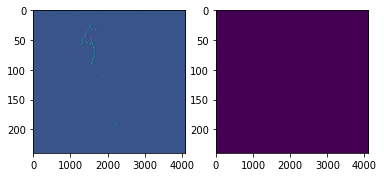

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:3
You selected: pion
You are wrong!


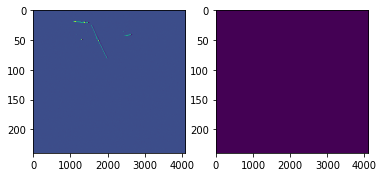

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:6
You selected: photon
You are wrong!


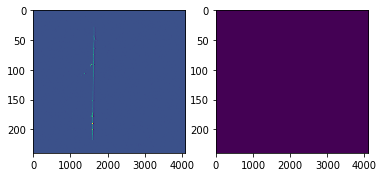

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:10
You selected: muon
You are correct!


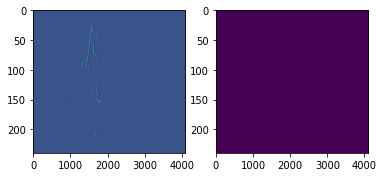

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:3
You selected: pion
You are wrong!


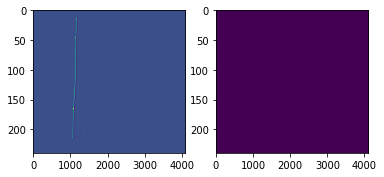

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:10
You selected: muon
You are wrong!


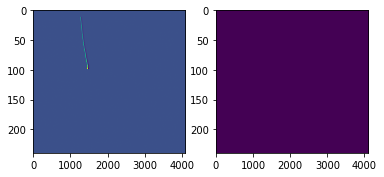

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:0
You selected: numu
You are wrong!


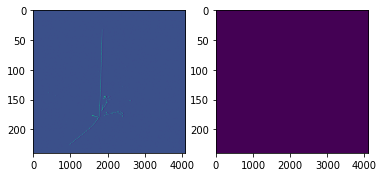

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:13
You selected: nue
You are wrong!


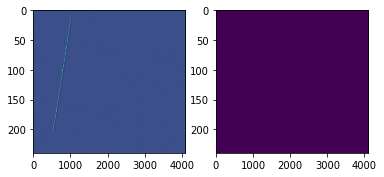

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:11
You selected: pionPlus
You are wrong!


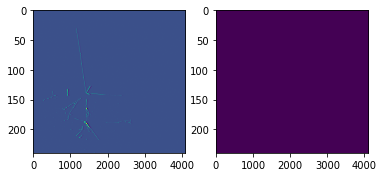

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:3
You selected: pion
You are wrong!


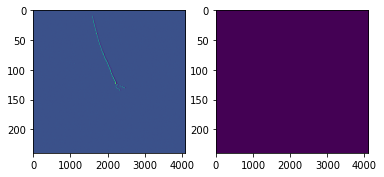

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:8
You selected: proton
You are wrong!


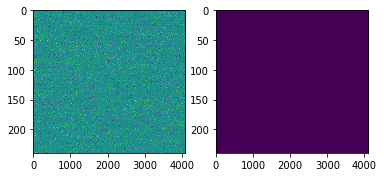

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:9
You selected: antielectron
You are wrong!


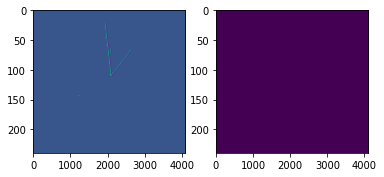

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:11
You selected: pionPlus
You are correct!


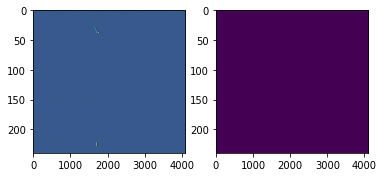

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:13
You selected: nue
You are wrong!


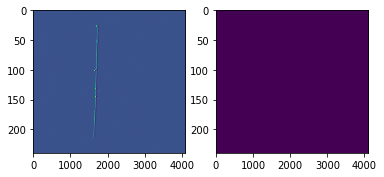

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:10
You selected: muon
You are correct!


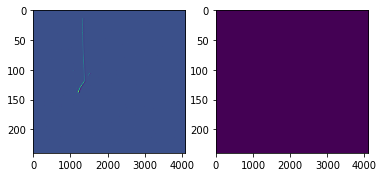

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:0
You selected: numu
You are wrong!


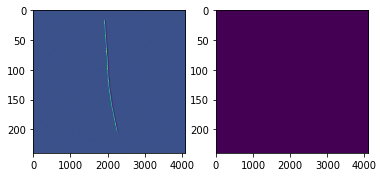

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:10
You selected: muon
You are wrong!


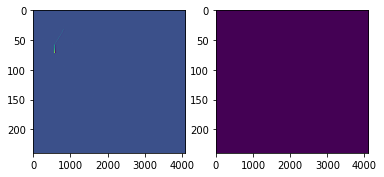

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:8
You selected: proton
You are wrong!


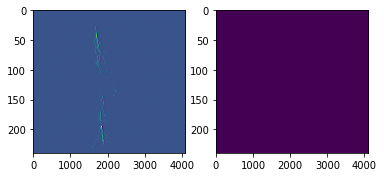

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:3
You selected: pion
You are wrong!


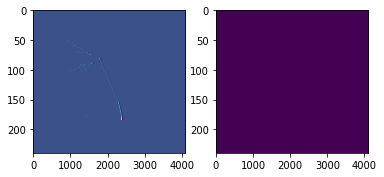

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:8
You selected: proton
You are wrong!


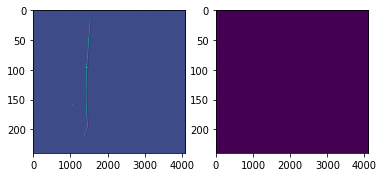

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:10
You selected: muon
You are wrong!


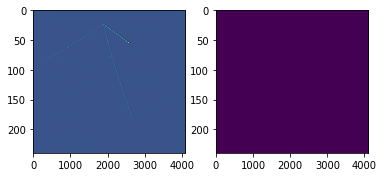

Select Type from: {0: 'numu', 1: 'kaonMinus', 3: 'pion', 6: 'photon', 8: 'proton', 9: 'antielectron', 10: 'muon', 11: 'pionPlus', 13: 'nue'}
Input:-1


In [28]:
Data_X = None
Data_Y = None
N_Events_perType=10

# Confusion matrix
cm=np.zeros([14,14])

for ParticleType in FileLists:
    # Open the first file
    FileName=FileLists[ParticleType][1] # we will take the 2nd file so we don't use the training sample for validation
    print "Opening:",FileName
    f=h5py.File(FileName,"r")
    
    # Get the images/features
    images=np.array(f["features"][:])
    
    # Warn if not enough events
    N_Events_read=images.shape[0]
    if not N_Events_read==N_Events_perType:
        print "Warning: Sample", FileName, "had only",N_Events_read,"events."
    
    # Assign labels
    labels=np.empty(N_Events_read)
    labels.fill(ParticleTypesIndexMap[ParticleType])

    # Store some of them
    try:
        # If we have already read some data, add to it
        Data_X=np.concatenate((Data_X,images))
        Data_Y=np.concatenate((Data_Y,labels))
    except:
        # If we haven't read any data yet
        Data_X=images
        Data_Y=labels
    
        
    f.close()

print Data_X.shape, Data_Y.shape

def shuffle_in_unison_inplace(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
    
Data_X,Data_Y=shuffle_in_unison_inplace(Data_X,Data_Y)  

status=np.zeros(len(Data_Y))
for i,image in enumerate(Data_X):
    PlotEvent(image)
    plt.show()

    
    print "Select Type from:", ParticleTypesIndexMapR
    try:
        answer=int(raw_input('Input:'))
    except ValueError:
        print "Not a number"
        
    # Stop loop
    if answer==-1:
        break
    
    print "You selected:", ParticleTypesIndexMapR[answer]
    
    if answer==Data_Y[i]:
        print "You are correct!"
        status[i]=1
    else:
        print "You are wrong!"
    
    # Confusion matrix
    cm[int(answer),int(Data_Y[i])]+=1

In [30]:
print "Row represents the predicted value, Column represents the truth"
for i in range(14):
    print cm[i,:]

Row represents the predicted value, Column represents the truth
[ 2.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  1.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  1.  0.  0.  2.  0.  1.  3.  0.  1.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  2.]
[ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  0.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.]


## Honors Problems:

### Exercise 3.4.1
Write a function that downsamples all of images by summing samples to reduce the 4096 long dimension of the data.

### Exercise 3.4.2
Write a function that returns a sub-region in the 4096 long dimention where the total charge is max.